In [20]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
import os
from plotly import graph_objects as go
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload

from scripts.charts import plot_line, plot_bar, plot_peak, print_charts_country
from scripts.features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_orig = pd.read_csv("data-processed/rki-reports.csv")
# df = pd.read_csv("data-processed/data_rki_prepared.csv")
df = pd.read_csv("dash/data/data_rki_apple_prepared_dash.csv")
df['date']=df['date'].astype('datetime64[ns]')
df.index = df.date

In [3]:
l = 'Bremen'
column = 'confirmed'
peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == -1), column].index.tolist()
df.loc[(df.index.isin(peak_index)) & (df.land == l), column]

date
2020-03-04      3
2020-04-19    585
Name: confirmed, dtype: int64

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def findpeak_trend(df):
    df_peak_log = df.loc[:, ['confirmed_peak_log']].dropna()
    
    days_pred_start = 10  # for how long to draw  the trend
    days_since_first_peak_start = 7  # how many days to wait since the first outbreak before estimating trend
    days_other_peak_starts = 7  # how many days since the second+ outbreak should pass before calculating trend

    # is we do not have enough data then exit
    if len(df_peak_log) < days_since_first_peak_start:
        df['peak_log_trend'] = np.NaN
        return df
    # find all indixes of outbreak beginnings
    peak_indixes = df.loc[df.confirmed_peak_date == -1].index.tolist()
    peak_indixes[0] = df_peak_log.index.min()
    
    # iterate over peak indixes
    for i, index in enumerate(peak_indixes):
        peak_index = peak_indixes[i]
        days_pred = days_pred_start
        if i == 0:
            # select y values since the beginning of the outbreak till defined number of days
            # and take a 3 days moving average for a smother trend
            days_add = days_since_first_peak_start
            
            # If we have two peak starts then the range we take to estmate the first should not be longer than the distance between 1st and 2nd
#             if len(peak_indixes) > 1:
#                 if days_add < len(df.loc[peak_index:peak_indixes[i+1]]):
#                     days_add = len(df.loc[peak_index:peak_indixes[i+1]])
#             else:
#                 # Else take all the days we have
#                 if days_add < len(df):
#                     days_add = len(df)
                    
            y = df_peak_log.loc[df_peak_log.index < peak_index +
                       datetime.timedelta(days=days_add), 'confirmed_peak_log'] #.rolling(3).median().dropna()
        else:
            # for the second+ outbreak use different number of minimum required days
            days_add = days_other_peak_starts
            # exis if we do not have enough data for an estimation
            if len(df.loc[peak_index:peak_index + datetime.timedelta(days=days_add)]) < days_other_peak_starts:
                return df
            else:
                # if we have more data to estimate second peak then use all of it
                days_other_peak_starts = len(df.loc[peak_index:df.index.max()])
                # if enough data then select y for estimating the trend
                y = df_peak_log.loc[(df_peak_log.index < df_peak_log.index.max()) &
                           (df_peak_log.index > peak_index), 'confirmed_peak_log'] #.rolling(3).median().dropna()

        # calculate X as number of days in Y and reshape to fit in LogReg model
        X = (y.index - y.index[0]).days.values.reshape(-1, 1)
    
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
        
        # train LogReg model
        reg = LinearRegression().fit(X, y)

        # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
        for days in [days_pred_start + i for i in [0, 10, 20, 35]]:
            X2 = (range(1, days + len(y)) + max(X)[0]).reshape(-1, 1)
            X2 = scaler.transform(X2)
            trend = reg.predict(X2)
            days_pred = days
            if min(trend) < 0:
                break
        
        

        # prepare y2 dataframe using index as a date range between the last date of y+1
        # and last date of y+days_estimated_for
        y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                                 y.index.max() + datetime.timedelta(days=days_pred))
        y2 = pd.DataFrame(index=y2_index, data=trend, columns=['peak_log_trend'])
        
        # remove extra negative values (if exist) except the first one (for clarity)
        try:
            first_negative_val = y2.loc[y2.peak_log_trend < 0].index[0]
            y2 = y2.loc[y2.index <= first_negative_val, 'peak_log_trend']
        except:
            pass
        # in case its the first peak simply merge DFs
        if i == 0:
            df = df.join(y2, how='outer')
        # otherwise merge and make sure that we fit all trends in the same column for easy plotting
        else:
            df = pd.merge(df, y2, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
            df['peak_log_trend'] = df.loc[:, ['peak_log_trend_x', 'peak_log_trend_y']].apply(
                lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
            df.drop(['peak_log_trend_x', 'peak_log_trend_y'], axis=1, inplace=True)

    return df

In [54]:
def add_trend_linear(df, column, date_range, days_add=15):
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    reg = LinearRegression().fit(X, y)

    # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
    X2 = (range(1, days_add + len(y)) + max(X)[0]).reshape(-1, 1)
    X2 = scaler.transform(X2)
    trend = reg.predict(X2)
    # prepare y2 dataframe using index as a date range between the last date of y+1
    # and last date of y+days_estimated_for
    y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                             y.index.max() + datetime.timedelta(days=days_add))
    y2 = pd.DataFrame(index=y2_index, data=trend, columns=[f'{column}_trend'])
    df = df.join(y2, how='outer')
    return df

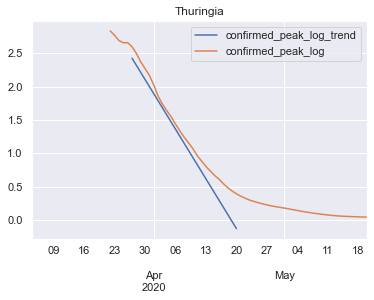

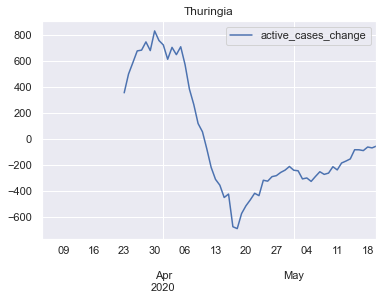

In [50]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_linear(df_ham, 'confirmed_peak_log', ['2020-03-20', '2020-04-05'])
dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
dd.loc[:, ['active_cases_change']].rolling(7).mean().plot(title=l)

In [48]:
df.land.unique()

array(['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hesse', 'Lower Saxony',
       'Mecklenburg-Western Pomerania', 'North Rhine-Westphalia',
       'Rhineland-Palatinate', 'Saarland', 'Saxony', 'Saxony-Anhalt',
       'Schleswig-Holstein', 'Thuringia'], dtype=object)

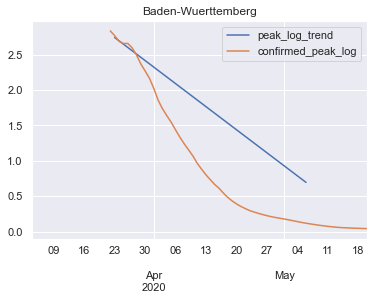

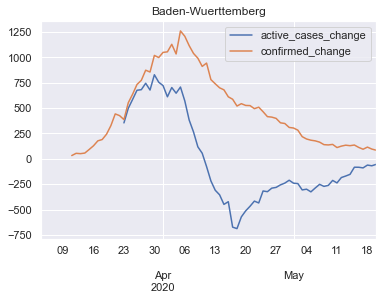

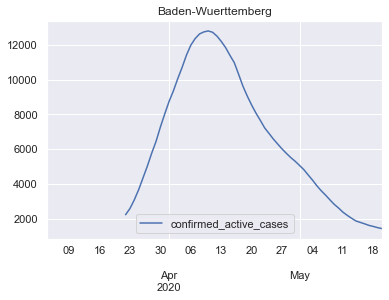

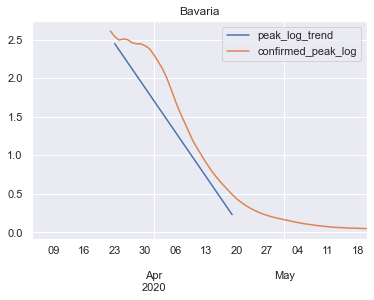

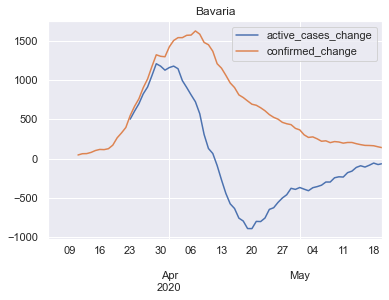

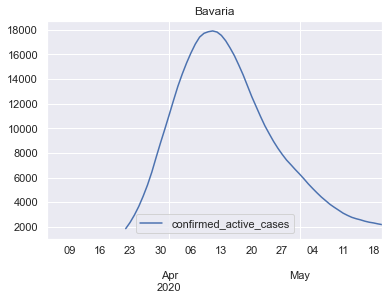

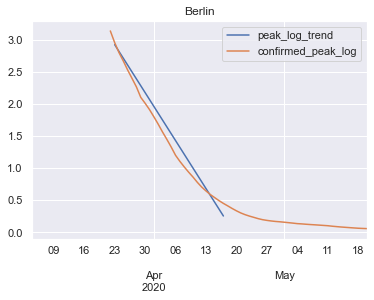

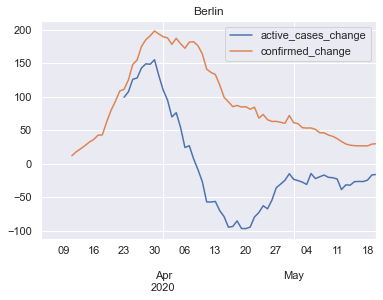

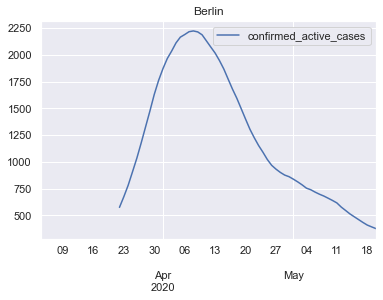

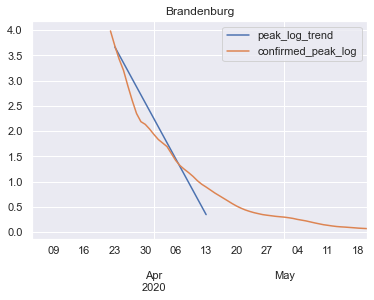

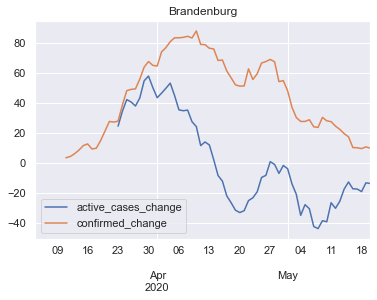

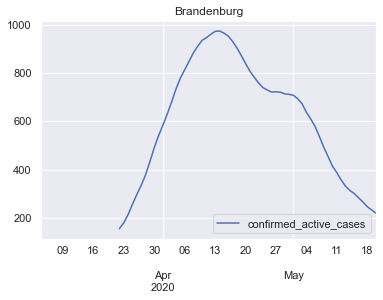

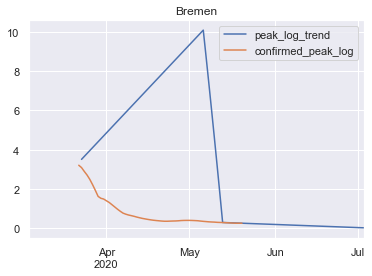

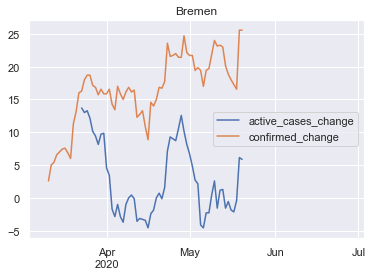

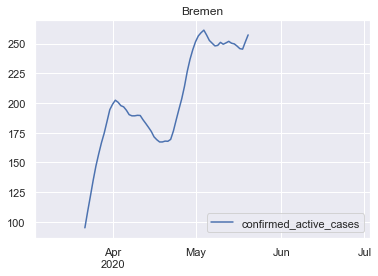

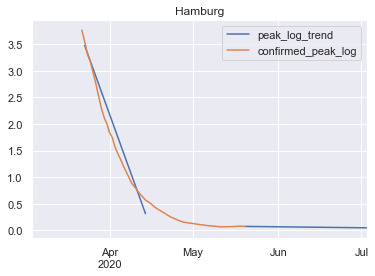

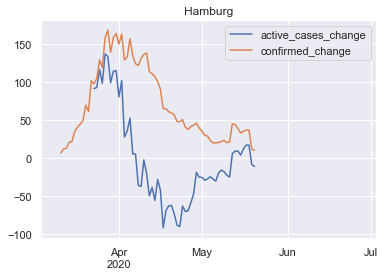

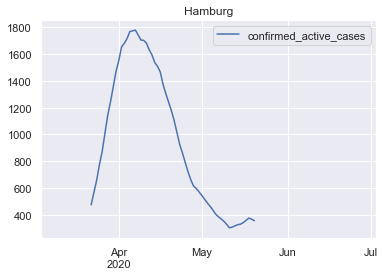

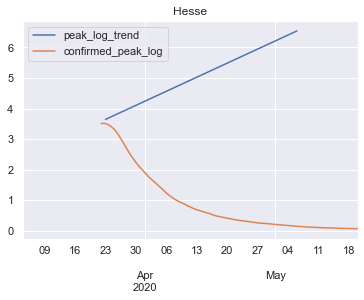

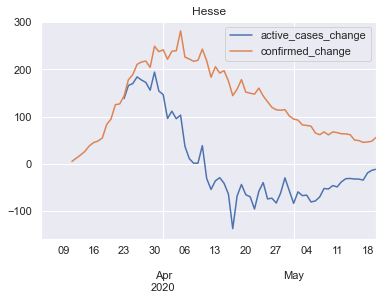

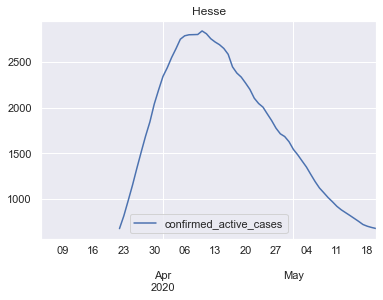

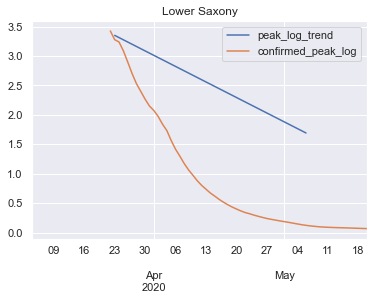

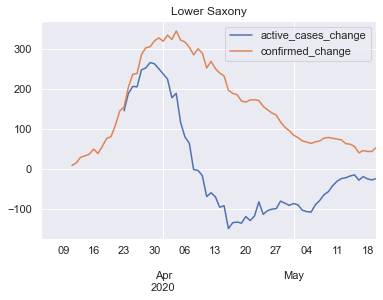

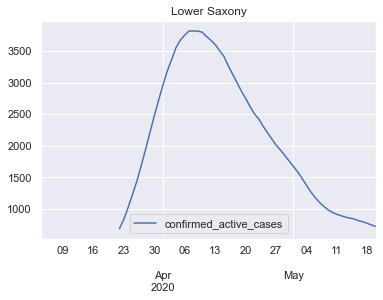

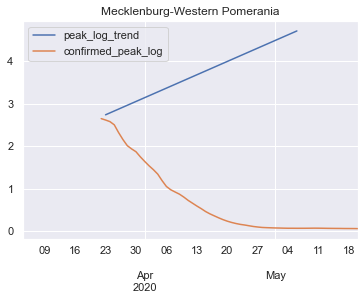

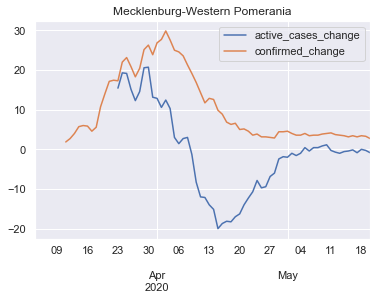

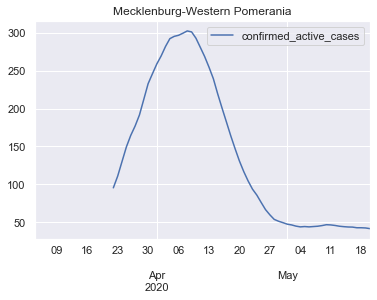

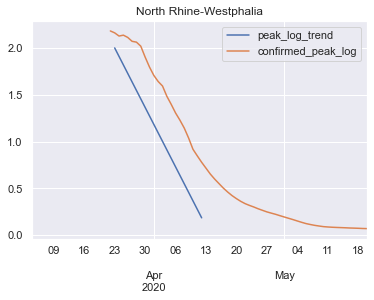

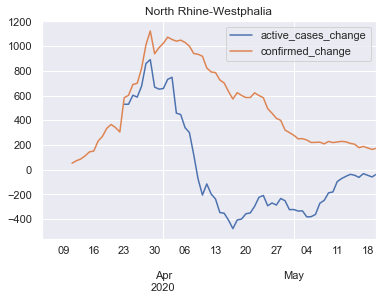

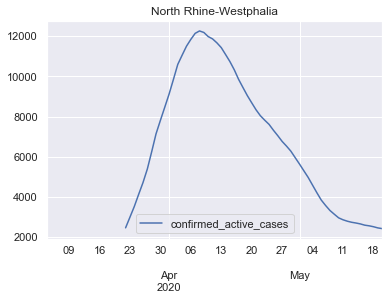

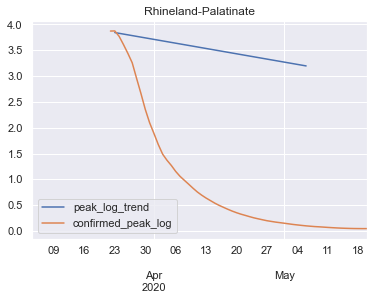

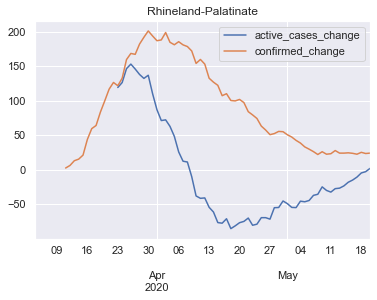

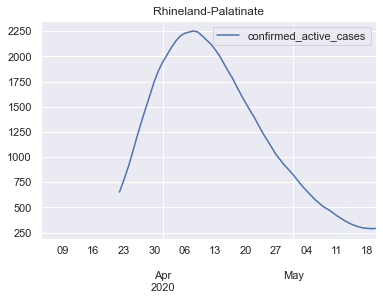

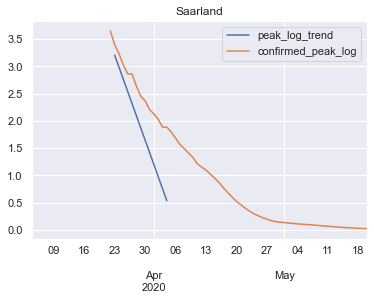

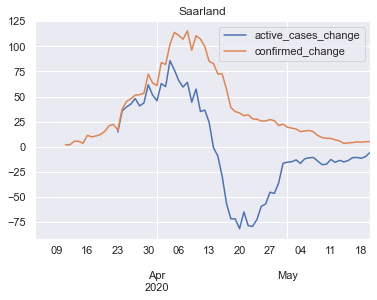

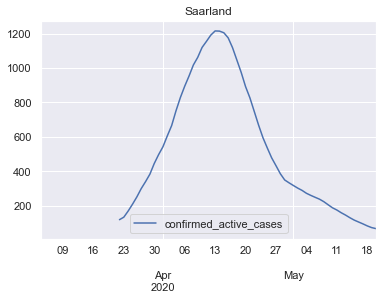

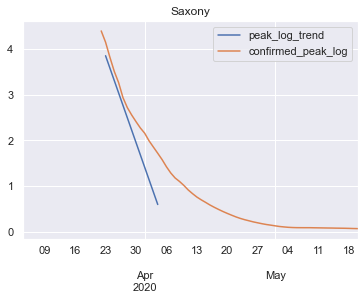

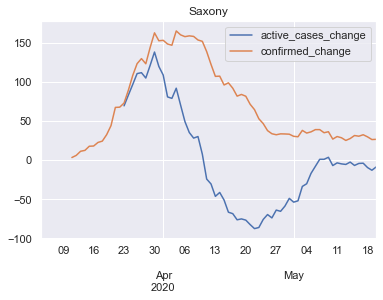

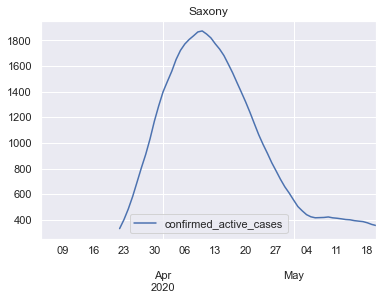

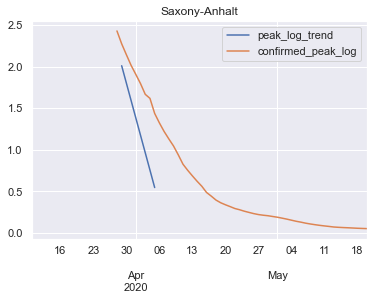

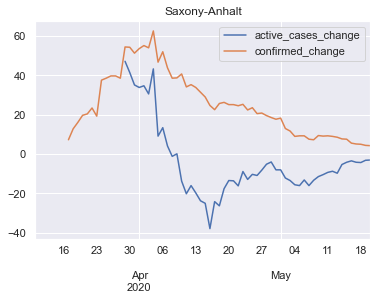

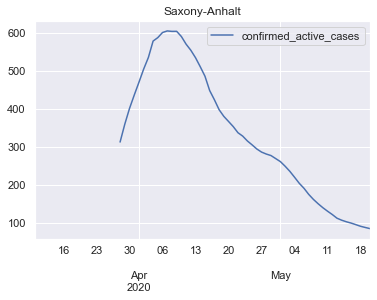

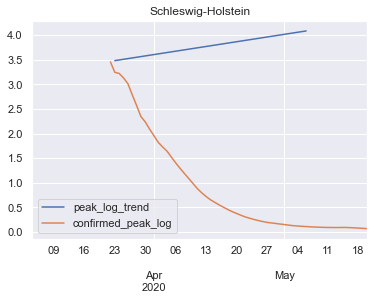

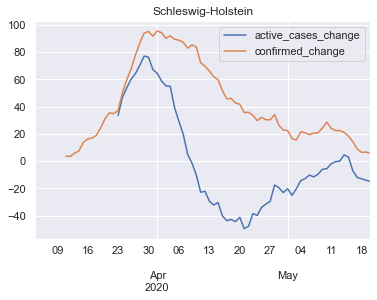

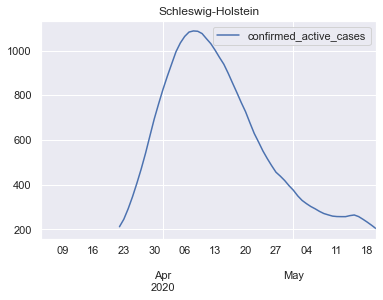

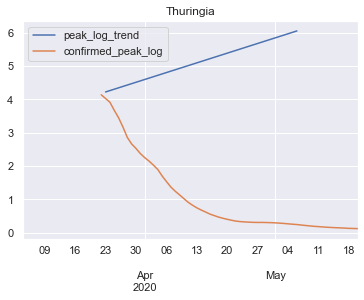

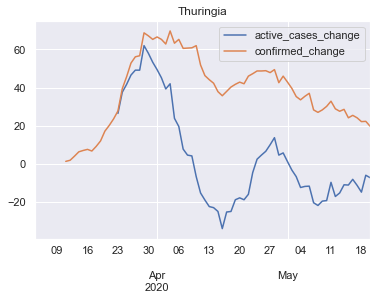

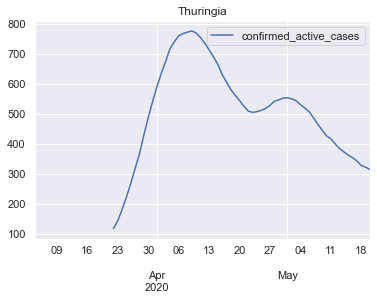

In [33]:
for l in df.land.unique():
    df_ham = df.loc[df.land == l].copy()
    df_ham.drop('peak_log_trend', axis=1, inplace=True)
    dd = findpeak_trend(df_ham)
    dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
    dd.loc[:, ['peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
    dd.loc[:, ['active_cases_change', 'confirmed_change']].rolling(7).mean().plot(title=l)
    dd.loc[:, ['confirmed_active_cases']].rolling(7).mean().plot(title=l)

In [31]:
# import matplotlib.pyplot as plt
plt.close('all')

In [8]:
from fbprophet import Prophet
import datetime
import pandas as pd


def add_forecast_prophet(df_in, column, window=60, ):
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame(
        {'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day', inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast], axis=1)
    df_result[f'peak_log_trend'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]

    return df_result


In [ ]:
# dd2 = add_forecast_prophet(df_ham, 'confirmed_peak_log')

In [ ]:
# dd2

In [ ]:
# dd2.loc[:, ['peak_log_trend', 'confirmed_peak_log']].plot()

In [116]:
import warnings
warnings.filterwarnings("ignore")
def add_trend_arima(df, column, date_range,  days_add=15, start=None):
    if start == None:
        start = df.index.max().date()
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    import statsmodels.api as sm
    mod = sm.tsa.statespace.SARIMAX(y,
#                                     order=(0, 0, 0),
#                                     seasonal_order=(0,0,0,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    
    pred_dynamic = results.get_prediction(start=pd.to_datetime(start), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y2 = pred_dynamic.predicted_mean
    y2.rename(f'{column}_trend', inplace=True)
    y2.columns = [f'{column}_trend']
    
    # Get forecast 500 steps ahead in future
    pred_uc = results.get_forecast(steps=days_add)
    pred_uc = pred_uc.predicted_mean
    pred_uc.rename(f'{column}_trend', inplace=True)
    pred_uc.columns = [f'{column}_trend']
    
#     print(y2,"\n")
#     print(pred_uc,"\n")
    
    print(results.summary().tables[1])
#     results.plot_diagnostics(figsize=(15, 12))
#     plt.show()

    df = df.join(y2, how='outer')
    df = pd.merge(df, pred_uc, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
    df[f'{column}_trend'] = df.loc[:, [f'{column}_trend_x', f'{column}_trend_y']].apply(
            lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
    df.drop([f'{column}_trend_x', f'{column}_trend_y'], axis=1, inplace=True)

    return df


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9633      0.017     55.800      0.000       0.929       0.997
sigma2         0.0214      0.011      1.939      0.052      -0.000       0.043


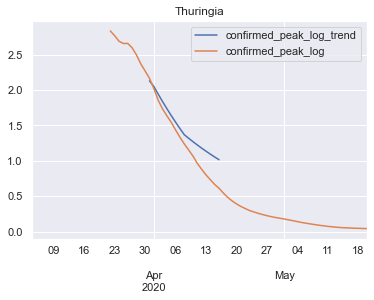

In [117]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, 'confirmed_peak_log', ['2020-03-04', '2020-04-01'], start='2020-03-25')
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5376      0.103      5.233      0.000       0.336       0.739
sigma2      9343.6318    875.467     10.673      0.000    7627.747    1.11e+04


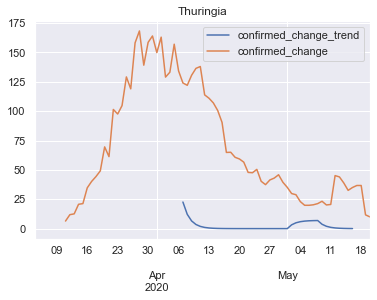

In [122]:
land = 'Hamburg'
column = 'confirmed_change'
df_ham = df.loc[(df.land == land)].copy()
# df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, column, ['2020-03-04', '2020-05-01'], start='2020-04-01')
dd.loc[:, [f'{column}_trend', column]].rolling(7).mean().plot(title=l)

In [123]:
from numpy import log10, datetime64, dtype
import pandas as pd
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator
from plotly import colors


def plot_lines_plotly(df_unfiltered, lands, column, _colors=colors.diverging.Temps * 3,
                      title=False, show_doubling=True, doubling_days=7, showlegend=False):

    df = df_unfiltered.loc[df_unfiltered.land.isin(lands), ['land', column, 'date',
                                                            'confirmed_peak_date']] #.dropna().sort_values(by=['land', 'date'], ascending=[True, True])
    df.set_index('date', inplace=True, drop=False)

    del df_unfiltered
    _doubling_column = f'double_x{doubling_days}'

    if show_doubling:
        def double_every_x_days(day, days_doubling, start_value=1):
            r = start_value * 2 ** (day / days_doubling)
            return r

        start_value = df.loc[(df[column] > 0) & (df.index == df.index.min()), column].median()
        if start_value < 1:
            start_value = 1

        # prepare empty dataframe to fill in
        date_range = pd.date_range(df.index.min(), df.index.max())
        df_index = pd.DataFrame(columns=['date', 'land', column],
                                data={'date': date_range, 'land': _doubling_column},
                                )
        # create a column with rank 1,2,3 etc for every 'land' in this case doubling types
        df_index['rn'] = df_index.groupby('land')['date'].rank(method='first', ascending=True)
        df_index[column] = df_index['rn'].apply(lambda x: double_every_x_days(x, doubling_days, start_value))
        df_index['date'] = df_index['date'].astype('datetime64[ns]')
        df_index.set_index('date', inplace=True, drop=False)
        df_index.sort_index(inplace=True, ascending=True)
        del df_index['rn']
        df = df.append(df_index, ignore_index=False, verify_integrity=False, sort=True)
        # df = df.rename_axis('dates_index').sort_values(by=['land', 'dates_index'], ascending=[True, True])

    # Create traces
    fig = go.Figure()

    _labels = df['land'].unique()

    #     max_x_range = len(df.index)
    _max_y_range = df.loc[df.land != _doubling_column, column].max() * 1.1
    if df.loc[:, column].min() > 0:
        _min_y_range = df.loc[(df.land != _doubling_column) & (df[column] > 0), column].min() / 2
    else:
        _min_y_range = df.loc[(df.land != _doubling_column), column].min() * 1.1

    _symbols = [x for i, x in enumerate(SymbolValidator().values) if i % 2 != 0]  # all markers
    _gray_color = 'rgb(204, 204, 204)'

    _mode_size = [8] * len(_labels)  # [8, 8, 12, 8]
    _line_size = [1] * len(_labels)  # [2, 2, 4, 2]

    for i, l in enumerate(_labels):
        # Adding Doubling x7 line
        if l == _doubling_column:
            fig.add_trace(go.Scatter(x=df.loc[df.land == l].index,
                                     y=df.loc[df.land == l, column],
                                     mode='lines',
                                     marker=dict(color=_gray_color,
                                                 size=_mode_size[i] - 2,
                                                 opacity=0.7,
                                                 symbol=_symbols[i + 2],
                                                 line=dict(
                                                     color=_colors[i],
                                                     width=1
                                                 )
                                                 ),
                                     name=l,
                                     line=dict(color=_gray_color,
                                               width=_line_size[i],
                                               dash='dot', ),
                                     connectgaps=True,
                                     ))
        # Adding all other lines
        else:
            fig.add_trace(go.Scatter(x=df.loc[df.land == l].index,
                                     y=df.loc[df.land == l, column],
                                     mode='lines+markers',
                                     marker=dict(color=_colors[i],
                                                 size=_mode_size[i] - 1,
                                                 opacity=0.7,
                                                 symbol=_symbols[i + 2],
                                                 line=dict(
                                                     color=_colors[i],
                                                     width=1
                                                 )
                                                 ),
                                     name=l,
                                     line=dict(color=_colors[i],
                                               width=_line_size[i]),
                                     connectgaps=False,
                                     ))

            # endpoints
            min_index, max_index = df.loc[df.land == l].index.min(), df.loc[df.land == l].index.max()
            fig.add_trace(go.Scatter(
                x=[min_index, max_index],
                y=[df.loc[(df.index == min_index) & (df.land == l)], df.loc[(df.index == max_index) & (df.land == l)]],
                mode='markers',
                name=l,
                marker=dict(color=_colors[i], size=_mode_size[i] + 2, ),
                showlegend=False,
            ))
        if 'confirmed_peak_date' in df.columns:
            # Mark when the peak is reached
            peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == 1), column].index.tolist()
            fig.add_trace(go.Scatter(
                x=peak_index,
                y=df.loc[(df.index.isin(peak_index)) & (df.land == l), column].tolist(),
                # y=[df.loc[(df.index == peak_index) & (df.land == l), column]],
                mode='markers',
                name=f"Peak {l}",
                marker=dict(
                    color='#008000',
                    size=15,
                    opacity=1,
                    symbol='triangle-down',
                    line=dict(
                        # color=_colors[i],
                        width=1
                    )),
                showlegend=False,
            ))
            # Mark when the new peak is starting (new wave is approaching)
            peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == -1), column].index.tolist()
            fig.add_trace(go.Scatter(
                x=peak_index,
                y=df.loc[(df.index.isin(peak_index)) & (df.land == l), column].tolist(),
                mode='markers',
                name=f"New Wave {l}",
                marker=dict(
                    color='#FF0000',
                    size=15,
                    opacity=1,
                    symbol='triangle-up',
                    line=dict(
                        # color=_colors[i],
                        width=1
                    )),
                showlegend=False,
            ))
            # # Mark when we predict the perk to be reached
            # peak_index = df.loc[(df.land == l) & (df['peak_log_trend'] < 0), column].index.tolist()
            # fig.add_trace(go.Scatter(
            #     x=peak_index,
            #     # y=[df.loc[df['peak_log_trend'] < 0, column].max().round(2)],
            #     y=df.loc[(df.index.isin(peak_index)) & (df.land == l), column].tolist(),
            #     mode='lines+markers',
            #     name=f"fc: {l}",
            #     marker=dict(
            #         color=_colors[i],
            #         size=20,
            #         opacity=1,
            #         symbol='triangle-up',
            #         line=dict(
            #             color=_colors[i],
            #             width=1
            #         )),
            #     showlegend=False,
            # ))

    # BUTTONS Changing Y Scale
    updatemenus = list([
        dict(active=1,
             direction="left",
             buttons=list([
                 dict(label='Log',
                      method='update',
                      args=[{'visible': [True, True]},
                            {  # 'title': 'Log scale',
                                'yaxis': {'type': 'log', 'range': [log10(_min_y_range), log10(_max_y_range)],
                                          'showgrid': False,
                                          'zeroline': False,
                                          'showline': False,
                                          'linecolor': '#1f2630',
                                          }}
                            ]
                      ),
                 dict(label='Linear',
                      method='update',
                      args=[{'visible': [True, True]},
                            {  # 'title': 'Linear scale',
                                'yaxis': {'type': 'linear', 'range': [_min_y_range, _max_y_range],
                                          # 'showticklabels': False,
                                          'showgrid': False,
                                          'zeroline': False,
                                          'showline': False,
                                          'linecolor': '#1f2630',
                                          }}
                            ]
                      ),
             ]),
             type='buttons',
             pad={"r": 10, "t": 10},
             showactive=True,
             x=0.10,
             xanchor="left",  # ['auto', 'left', 'center', 'right']
             y=1,
             yanchor='top',  # ['auto', 'top', 'middle', 'bottom']
             )
    ])

    # UPDATE LAYOUT, Axis, Margins, Size, Legend, Background
    fig.update_layout(
        updatemenus=updatemenus,
        dragmode="select",
        clickmode='event+select',
        xaxis=dict(
            showline=True,
            showgrid=False,
            showticklabels=True,
            linecolor=_gray_color,
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Arial',
                size=12,
                color='#2cfec1',  # 'rgb(82, 82, 82)',
            ),
            #                 range=[0,max_x_range],
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=True,
            tickfont=dict(color='#2cfec1'),
            range=[_min_y_range, _max_y_range],
        ),
        margin=dict(
            autoexpand=True,
            l=10,
            r=100,
            t=10,
            b=100,
        ),
        showlegend=showlegend,
        legend_orientation="v",
        legend=dict(
            x=1.05,
            y=0, ),
        paper_bgcolor="#1f2630",  # "#F4F4F8",
        plot_bgcolor="#1f2630",  # 'white'
        font=dict(color='#2cfec1'),
        autosize=True,
        # width=800,
        # height=500,
    )

    # ANNOTATIONS
    annotations = []
    # Adding labels
    for i, l in enumerate(_labels):
        min_index, max_index = df.loc[df.land == l].index.min(), df.loc[df.land == l].index.max()
        if l == _doubling_column:
            # labeling x7 line
            x = (min_index + (max_index - min_index) / 2)
            try:
                x = str(x.date())
            except:
                pass
            y = df.loc[(df.land == l) & (df.index == x), column].values[0]
            annotations.append(dict(xref='x', x=x, y=y,
                                    xanchor='center', yanchor='middle',
                                    text="double every 7 days",
                                    font=dict(family='Arial',
                                              size=12,
                                              color=_gray_color, ),
                                    showarrow=False))
        else:
            # labeling the right_side of the plot
            y = df.loc[(df.land == l) & (df.index == max_index), column].values[0]
            annotations.append(dict(xref='paper',
                                    x=0.95,
                                    y=y,
                                    xanchor='left', yanchor='middle',
                                    text=l,  # f"{col}: {int(y)}",
                                    font=dict(family='Arial',
                                              size=12,
                                              color=_colors[i]),
                                    showarrow=False))

            # ======================================= ANNOTATE DATA OUTLIERS ========================
            annotation_style_outliers = dict(
                xref="x",
                yref="y",
                showarrow=True,
                arrowhead=2,
                arrowsize=1.2,
                arrowwidth=1.2,
                arrowcolor=_gray_color,
                # bordercolor=_gray_color,
                # borderwidth=2,
                # borderpad=4,
                # bgcolor=_gray_color,  # "#ff7f0e"
                opacity=0.5,
                ax=0,
                ay=-40,
                font=dict(family='Garamond',
                          size=12,
                          color=_gray_color
                          ),
            )
            if l == 'Hamburg':
                try:
                    annotation = annotation_style_outliers
                    annotation['text'] = 'HH: Recorded old cases'
                    x = df.loc[(df.date == '2020-05-12') & (df.land == l), [column]].index[0]
                    y = df.loc[(df.index == x) & (df.land == l), column].values[0]
                    annotation['x'] = x
                    annotation['y'] = df.loc[(df.index == x) & (df.land == l), column].values[0]
                    annotations.append(annotation)
                except:
                    pass
            # =================================== END ANNOTATE DATA OUTLIERS ========================

    # Title
    if title:
        annotations.append(dict(xref='paper', yref='paper', x=0, y=1,
                                xanchor='left', yanchor='bottom',
                                text=title,
                                font=dict(family='Garamond',
                                          size=30,
                                          color='#7fafdf' #'rgb(37,37,37)'
                                          ),
                                showarrow=False))
    # Source
    annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.06,
                            xanchor='center', yanchor='top',
                            text="Data Source: <a href='https://www.rki.de/'>Robert Koch Institute</a>"
                                 ", <a href='https://www.apple.com/covid19/mobility'>Apple</a><br>"
                                 "<i>Charts: <a href='https://www.linkedin.com/in/sergeychekanskiy'>Sergey Chekanskiy</a></i>",
                            font=dict(family='Garamond',
                                      size=12,
                                      color='#7fafdf'),
                            showarrow=False))

    fig.update_layout(annotations=annotations)

    return fig


In [158]:
df_jh_world = pd.read_csv('dash/data/data_jhu_world.csv')
df_jh_world.loc[:, 'population_100k'] = df_jh_world.loc[:, 'population_wb'] / 100000
df_jh_world['date'] = df_jh_world['date'].astype('datetime64[ns]')
df_jh_world.index = df_jh_world.date

In [161]:
# sorted(df_jh_world.round(3)['confirmed_change_per_100k'], reverse=True)

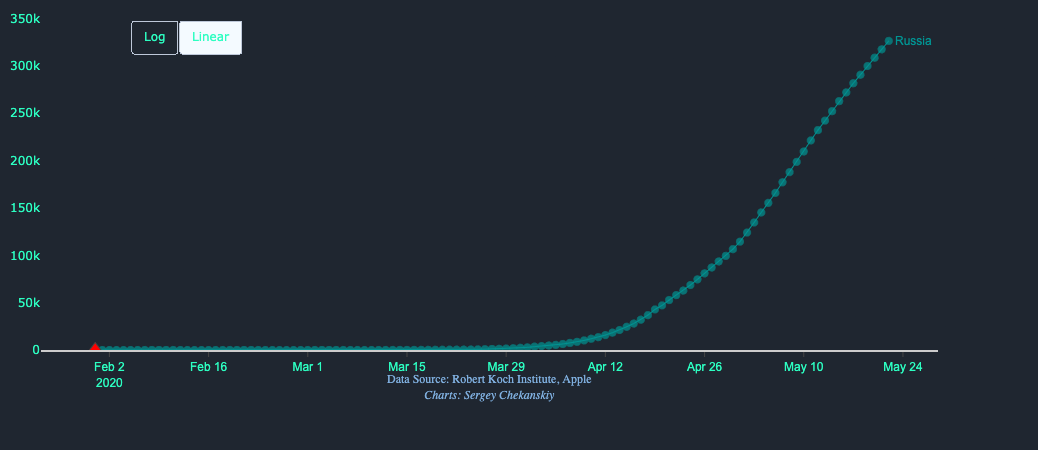

In [130]:
figure = plot_lines_plotly(df_jh_world, ['Russia'], 'confirmed',
                                       show_doubling=False, doubling_days=7, showlegend=False,
                                       )
figure.show()

In [145]:
df2 = df_jh_world.rename_axis('dd', axis=1)
selected_column = 'confirmed'
ro = df2.groupby('land').rolling(7, on='date').mean().reset_index(drop=False).loc[:,
         ['date', 'land', selected_column]]
df = df2.merge(ro, on=['date', 'land'], suffixes=('', '_weekly')).round(3)

ValueError: cannot insert date, already exists

In [133]:
df_jh_world.columns

Index(['state', 'land', 'lat', 'lng', 'iso_code', 'date', 'confirmed',
       'confirmed_avg3', 'confirmed_change', 'confirmed_change_avg3',
       'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'confirmed_per_100k', 'confirmed_change_per_100k', 'dead', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days_3w_avg3', 'dead_day_since_10', 'dead_per_100k',
       'dead_change_per_100k', 'region_wb', 'population_wb',
       'population_100k'],
     

In [144]:
df_rki_orig.columns

Index(['Unnamed: 0', 'land', 'driving', 'walking', 'transit', 'date',
       'confirmed', 'dead', 'name', 'iso_code', 'capital', 'area',
       'population', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'confirmed_per_100k', 'confirmed_change_per_100k', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days_3w_avg3', 'dead_day_since_10', 'dead_per_100k',
       'dead_change_p

In [147]:
df_jh_world

,state,land,lat,lng,iso_code,date,confirmed,confirmed_avg3,confirmed_change,confirmed_change_avg3,confirmed_change_3w,confirmed_change_pct,confirmed_change_pct_avg3,confirmed_change_pct_3w,confirmed_doubling_days,confirmed_doubling_days_3w,confirmed_doubling_days_avg3,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_log,confirmed_peak_date,confirmed_day_since_10,confirmed_per_100k,confirmed_change_per_100k,dead,dead_avg3,dead_change,dead_change_avg3,dead_change_3w,dead_change_pct,dead_change_pct_avg3,dead_change_pct_3w,dead_doubling_days,dead_doubling_days_3w,dead_doubling_days_avg3,dead_doubling_days_3w_avg3,dead_day_since_10,dead_per_100k,dead_change_per_100k,region_wb,population_wb,population_100k
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-24,NaN,Afghanistan,33.0,65.0,AFG,2020-02-24,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,-1,0,0.002690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,NaN,NaN,South Asia,37172386.0,371.72386
2020-02-25,NaN,Afghanistan,33.0,65.0,AFG,2020-02-25,1.0,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,100.000,0.000,NaN,NaN,NaN,NaN,NaN,0,0,0.002690,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,NaN,NaN,South Asia,37172386.0,371.72386
2020-02-26,NaN,Afghanistan,33.0,65.0,AFG,2020-02-26,1.0,1.0,0.0,NaN,NaN,0.000000,NaN,NaN,100.000,0.000,75.0,0.0,NaN,NaN,NaN,0,0,0.002690,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN,South Asia,37172386.0,371.72386
2020-02-27,NaN,Afghanistan,33.0,65.0,AFG,2020-02-27,1.0,1.0,0.0,0.0,NaN,0.000000,0.000,NaN,100.000,0.000,100.0,0.0,NaN,NaN,NaN,0,0,0.002690,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN,South Asia,37172386.0,371.72386
2020-02-28,NaN,Afghanistan,33.0,65.0,AFG,2020-02-28,1.0,1.0,0.0,0.0,NaN,0.000000,0.000,NaN,100.000,0.000,100.0,0.0,NaN,NaN,NaN,0,0,0.002690,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN,South Asia,37172386.0,371.72386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,NaN,Zimbabwe,-20.0,30.0,ZWE,2020-05-18,46.0,44.0,2.0,2.0,14.0,0.045455,0.048,0.153846,15.593,4.844,36.0,28.0,12.0,2.0,0.302,0,42,0.318582,0.013851,4.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,100.0,0.0,100.0,0.0,0,0.027703,0.0,Sub-Saharan Africa,14439018.0,144.39018
2020-05-19,NaN,Zimbabwe,-20.0,30.0,ZWE,2020-05-19,46.0,46.0,0.0,2.0,14.0,0.000000,0.045,0.000000,100.000,100.000,37.0,28.0,12.0,0.0,0.302,0,43,0.318582,0.000000,4.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,100.0,0.0,100.0,0.0,0,0.027703,0.0,Sub-Saharan Africa,14439018.0,144.39018
2020-05-20,NaN,Zimbabwe,-20.0,30.0,ZWE,2020-05-20,48.0,46.0,2.0,1.0,16.0,0.043478,0.022,0.142857,16.286,5.191,58.0,53.0,14.0,2.0,0.345,0,44,0.332433,0.013851,4.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,100.0,0.0,100.0,0.0,0,0.027703,0.0,Sub-Saharan Africa,14439018.0,144.39018


In [146]:
df_rki_orig

,Unnamed: 0,land,driving,walking,transit,date,confirmed,dead,name,iso_code,capital,area,population,confirmed_avg3,confirmed_change,confirmed_change_avg3,confirmed_change_3w,confirmed_change_pct,confirmed_change_pct_avg3,confirmed_change_pct_3w,confirmed_doubling_days,confirmed_doubling_days_3w,confirmed_doubling_days_avg3,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_log,confirmed_peak_date,confirmed_day_since_10,confirmed_per_100k,confirmed_change_per_100k,dead_avg3,dead_change,dead_change_avg3,dead_change_3w,dead_change_pct,dead_change_pct_avg3,dead_change_pct_3w,dead_doubling_days,dead_doubling_days_3w,dead_doubling_days_avg3,dead_doubling_days_3w_avg3,dead_day_since_10,dead_per_100k,dead_change_per_100k
0,231,Baden-Wuerttemberg,105.20,NaN,NaN,2020-03-04,50,0,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,-1,1,0.452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,0,0.000,NaN
1,232,Baden-Wuerttemberg,108.75,NaN,NaN,2020-03-05,73,0,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,NaN,23.0,NaN,NaN,0.460,NaN,NaN,1.832,0.000,NaN,NaN,NaN,NaN,NaN,0,2,0.659,0.208,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,0,0.000,0.000
2,233,Baden-Wuerttemberg,119.53,NaN,NaN,2020-03-06,96,0,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,73.0,23.0,NaN,NaN,0.315,NaN,NaN,2.531,0.000,2.0,0.0,NaN,NaN,NaN,0,3,0.867,0.208,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0,0.000,0.000
3,234,Baden-Wuerttemberg,114.63,NaN,NaN,2020-03-07,170,0,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,109.0,74.0,36.0,NaN,0.771,0.493,NaN,1.213,0.000,2.0,0.0,NaN,NaN,NaN,0,4,1.536,0.669,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0,0.000,0.000
4,235,Baden-Wuerttemberg,109.06,NaN,NaN,2020-03-08,182,0,Baden-Wuerttemberg,BW,Stuttgart,35677,11069533,154.0,12.0,46.0,NaN,0.071,0.422,NaN,10.162,0.000,4.0,0.0,NaN,NaN,NaN,0,5,1.644,0.108,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000,0.000,0.0,0.0,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,1223,Thuringia,112.00,NaN,NaN,2020-05-19,2750,147,Thuringia,TH,Erfurt,16202,2143145,2739.0,10.0,14.0,606.0,0.004,0.005,0.016,100.000,43.321,100.0,34.0,298.0,-13.0,0.115,0,69,128.319,0.467,141.0,8.0,3.0,69.0,0.058,0.022,0.123,12.387,5.972,75.0,36.0,44,6.859,0.373
1286,1224,Thuringia,124.67,NaN,NaN,2020-05-20,2760,149,Thuringia,TH,Erfurt,16202,2143145,2750.0,10.0,11.0,590.0,0.004,0.004,0.017,100.000,42.350,100.0,40.0,248.0,-50.0,0.094,0,70,128.785,0.467,146.0,2.0,5.0,69.0,0.014,0.035,0.029,51.292,24.258,43.0,20.0,45,6.953,0.093
1287,1225,Thuringia,127.77,NaN,NaN,2020-05-21,2796,151,Thuringia,TH,Erfurt,16202,2143145,2766.0,36.0,16.0,542.0,0.013,0.006,0.061,53.487,11.703,88.0,35.0,263.0,15.0,0.099,0,71,130.465,1.680,149.0,2.0,4.0,66.0,0.013,0.027,0.029,51.985,24.258,42.0,20.0,46,7.046,0.093
1288,1276,Thuringia,127.77,NaN,NaN,2020-05-22,2818,151,Thuringia,TH,Erfurt,16202,2143145,2792.0,22.0,26.0,495.0,0.008,0.009,0.041,88.439,17.421,74.0,21.0,262.0,-1.0,0.098,0,72,131.492,1.027,150.0,0.0,2.0,58.0,0.000,0.013,0.000,100.000,100.000,64.0,43.0,47,7.046,0.000


In [143]:
df_rki_orig = pd.read_csv('dash/data/data_rki_apple_prepared_dash.csv')
df_rki_orig['date'] = df_rki_orig['date'].astype('datetime64[ns]')

In [141]:
selected_colum = 'confirmed'

ro = df_rki_orig.groupby('land').rolling(7, on='date').mean().reset_index(drop=False).loc[:,
         ['date', 'land', selected_colum]]
df = df_rki_orig.merge(ro, on=['date', 'land'], suffixes=('', '_weekly')).round(3)